# Image based cell cycle label 

In [1]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from anndata import AnnData
from tifffile import imread
from skimage.measure import regionprops

# Customized packages
import starmap.sc_util as su

# test()

## Input

In [2]:
# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

In [3]:
# Load adata
adata = sc.read_h5ad('./output/2021-10-06-Rena-EU-starmap-cc.h5ad')
adata

AnnData object with n_obs × n_vars = 19603 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'condition', 'phase_ref'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    layers: 'cytoplasm', 'er', 'nucleus', 'outer_cytoplasm'

In [5]:
adata.obs['sample'].value_counts()

1h_labeling_1h_wash    4421
1h_labeling            4204
1h_labeling_4h_wash    3727
1h_labeling_2h_wash    3521
1h_labeling_6h_wash    2303
20h_labeling           1427
Name: sample, dtype: int64

## Nuclei intensity

In [34]:
# Load dapi sum image
current_sample = '1h_labeling'
current_img_path = os.path.join(current_sample, "dapi_3d.tif")
current_dapi_img = imread(current_img_path)

current_seg_path = os.path.join(current_sample, "nuclei.tif")
current_seg_img = imread(current_seg_path)

In [35]:
# Get nuclei intensity 
good_cells = adata.obs.loc[adata.obs['sample'] == current_sample, 'orig_index'].values
intensity = []
nuclei_volume = []
for i, region in enumerate(regionprops(current_seg_img, current_dapi_img)):
    if region.label - 1 in good_cells:
        intensity.append(region.mean_intensity * region.area)
        nuclei_volume.append(region.area)
        
print(len(intensity))

4204


Trying to set attribute `.obs` of view, copying.


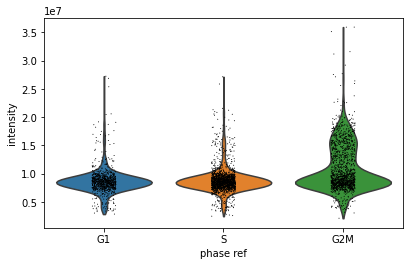

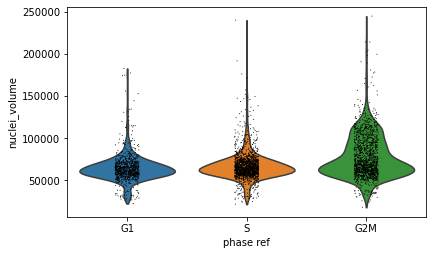

In [36]:
# Plot
sdata = adata[adata.obs['sample'] == current_sample, ]
sdata.obs['intensity'] = intensity
sdata.obs['nuclei_volume'] = nuclei_volume
sdata.obs['phase_ref'] = sdata.obs['phase_ref'].cat.reorder_categories(['G1', 'S', 'G2M'])

sc.pl.violin(sdata, 'intensity', groupby='phase_ref')
sc.pl.violin(sdata, 'nuclei_volume', groupby='phase_ref')

<AxesSubplot:xlabel='intensity', ylabel='Density'>

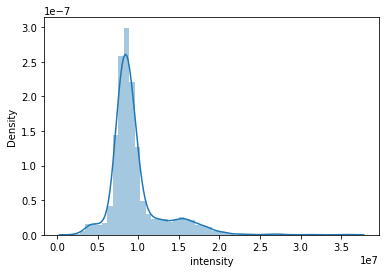

In [37]:
sns.distplot(sdata.obs['intensity'])

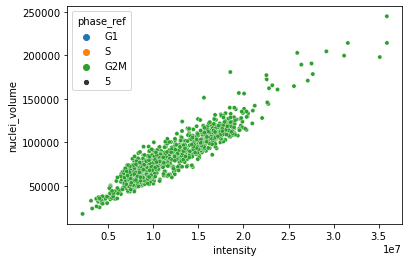

In [38]:
current_plot = sns.scatterplot(x='intensity', y='nuclei_volume', hue='phase_ref', data=sdata.obs.loc[sdata.obs['phase_ref'] == 'G2M',], size=5)
# current_plot.set(xscale="log")
# current_plot.set(yscale="log")

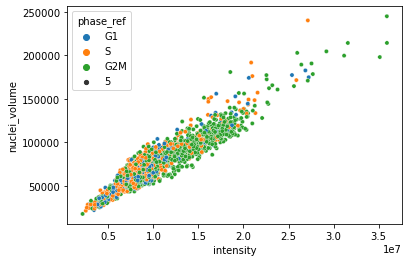

In [39]:
current_plot = sns.scatterplot(x='intensity', y='nuclei_volume', hue='phase_ref', data=sdata.obs, size=5)

In [40]:
sdata.obs['intensity'] = sdata.obs['intensity'] / sdata.obs['intensity'].max()
sdata.obs['nuclei_volume'] = sdata.obs['nuclei_volume'] / sdata.obs['nuclei_volume'].max()

<AxesSubplot:xlabel='intensity', ylabel='Density'>

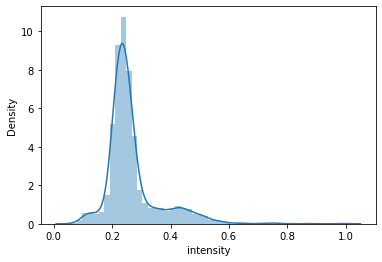

In [41]:
sns.distplot(sdata.obs['intensity'])

In [42]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
sdata.obs.to_csv(f'./output/{date}-{current_sample}-obs.csv')

## Intensity for all samples

In [44]:
adata.obs['nuclei_intensity'] = 0

for current_sample in adata.obs['sample'].unique():
    # Load dapi sum image
    current_img_path = os.path.join(current_sample, "dapi_3d.tif")
    current_dapi_img = imread(current_img_path)

    current_seg_path = os.path.join(current_sample, "nuclei.tif")
    current_seg_img = imread(current_seg_path)

    # Get nuclei intensity 
    good_cells = adata.obs.loc[adata.obs['sample'] == current_sample, 'orig_index'].values
    intensity = []
    nuclei_volume = []
    for i, region in enumerate(regionprops(current_seg_img, current_dapi_img)):
        if region.label - 1 in good_cells:
            intensity.append(region.mean_intensity * region.area)
            nuclei_volume.append(region.area)

    adata.obs.loc[adata.obs['sample'] == current_sample, 'nuclei_intensity'] = intensity


In [46]:
date = datetime.today().strftime('%Y-%m-%d')
adata.obs.to_csv(f'./output/{date}-obs.csv')